In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
# number of matches in upcoming week
n_matches = 7

In [10]:
df = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [11]:
spare = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [12]:
df.head(n_matches)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,14-Feb-20,Blues,Crusaders,0,0,3.47,24.74,1.31,11
1,14-Feb-20,Rebels,Waratahs,0,0,1.61,20.81,2.35,11
2,15-Feb-20,Sunwolves,Chiefs,0,0,9.49,40.78,1.05,11
3,15-Feb-20,Hurricanes,Sharks,0,0,1.31,24.35,3.41,11
4,15-Feb-20,Brumbies,Highlanders,0,0,1.44,22.14,2.78,11
5,15-Feb-20,Lions,Stormers,0,0,2.62,22.26,1.50,11
6,15-Feb-20,Jaguares,Reds,0,0,1.17,30.03,4.88,10


### Get win streak

In [13]:
def bool_to_int(bool_val):
    if bool_val:
        return 1
    else:
        return -1

def get_home_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Home Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try: 
        last_result = bool_to_int(next(results)[-1])
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak
        

def get_away_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Away Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try:
        last_result = bool_to_int(next(results)[-1])*-1
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])*-1
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak

### Cleaning and Feature Engineering

In [14]:
countries = {'Crusaders': 'NZ',
             'Chiefs': 'NZ',
             'Blues': 'NZ',
             'Hurricanes': 'NZ',
             'Highlanders': 'NZ',
             'Bulls': 'SA',
             'Cheetahs': 'SA',
             'Kings': 'SA',
             'Lions': 'SA',
             'Sharks': 'SA',
             'Stormers': 'SA',
             'Brumbies': 'AUS',
             'Force': 'AUS',
             'Rebels': 'AUS',
             'Reds': 'AUS',
             'Waratahs': 'AUS',
             'Jaguares': 'ARG',
             'Sunwolves': 'JPN'}

def cleanup(df):
    
    # convert Date to datetime
    df['Date'] = pd.to_datetime(df.Date)
    
    # create response variable
    df['home_margin'] = df['Home Score'] - df['Away Score']
    
    # create home_win column
    df['home_win'] = (df['Home Score'] > df['Away Score'])
    
    df.drop(['Home Score', 'Away Score'], axis=1, inplace=True)
    
    # create home_streak and away_streak columns
    home_streaks = []
    away_streaks = []
    for row in df.itertuples():
        home_team = row[2]
        away_team = row[3]
        date = row[1]
        home_streaks.append(get_home_streak(home_team, date))
        away_streaks.append(get_away_streak(away_team, date))
        
    df['home_streak'] = home_streaks
    df['away_streak'] = away_streaks
    
    # add nationalities
    df['home_nationality'] = df['Home Team'].replace(countries)
    df['away_nationality'] = df['Away Team'].replace(countries)
    
    # encode nationalities
    df = pd.get_dummies(df, prefix='home_country', columns=['home_nationality'])
    df = pd.get_dummies(df, prefix='away_country', columns=['away_nationality'])
    
    # encode team names
    df = pd.get_dummies(df, prefix='home_team', columns=['Home Team'])
    df = pd.get_dummies(df, prefix='away_team', columns=['Away Team'])
    
    # aggregate odds into single probability variable
    df['home_odds'] = df['Away Odds'] / (df['Home Odds'] + df['Away Odds'])
    
    # drop irrelevent columns
    df.drop(['Date', 'Home Odds', 'Draw Odds', 'Away Odds',
             'home_country_ARG', 'home_country_JPN', 'away_country_ARG',
             'away_country_JPN', 'home_team_Cheetahs', 'away_team_Cheetahs',
             'home_team_Kings', 'away_team_Kings', 'home_team_Force',
             'away_team_Force'], 
            axis=1,
            inplace=True)
    
    return df

In [15]:
df = cleanup(df)
df.head()

,Bookmakers Surveyed,home_margin,home_win,home_streak,away_streak,home_country_AUS,home_country_NZ,home_country_SA,away_country_AUS,away_country_NZ,...,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs,home_odds
0,11,0,False,-2,-2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.274059
1,11,0,False,-3,-2,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0.593434
2,11,0,False,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.099620
3,11,0,False,2,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.722458
4,11,0,False,10,-3,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.658768


In [16]:
import seaborn as sns

/Users/kierandonnelly/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


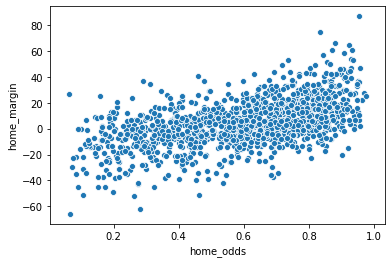

In [17]:
sns.scatterplot(x='home_odds', y='home_margin', data=df)

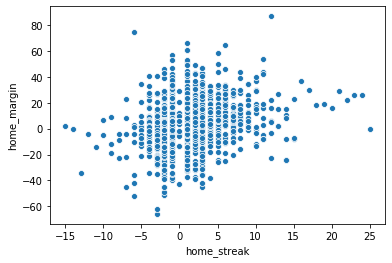

In [18]:
sns.scatterplot(x='home_streak', y='home_margin', data=df)

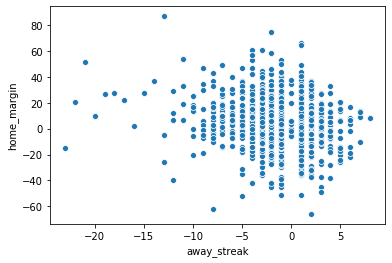

In [19]:
sns.scatterplot(x='away_streak', y='home_margin', data=df)

In [20]:
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Bookmakers Surveyed,1366.0,10.005857,0.085391,9.0,10.0,10.0,10.0,11.0
home_margin,1366.0,4.375549,17.407849,-66.0,-6.0,5.0,15.0,87.0
home_streak,1366.0,1.251098,3.989811,-15.0,-1.0,1.0,3.0,25.0
away_streak,1366.0,-1.119327,3.377967,-23.0,-3.0,-1.0,1.0,8.0
home_country_AUS,1366.0,0.295022,0.456220,0.0,0.0,0.0,1.0,1.0


### TO DO: Engineer more features which capture form, attack, defense etc

In [21]:
X = df[n_matches:].drop(['home_margin', 'home_win'], axis=1)
y = df[n_matches:].home_margin.values

In [22]:
# we will use these later:
X_temp = df[:n_matches].drop(['home_margin', 'home_win'], axis=1)
y_temp = df[:n_matches].home_margin.values

In [23]:
y.shape

(1359,)

In [24]:
X.shape

(1359, 40)

### XG Boost

In [25]:
# set up train/test split with 80/20 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
from xgboost import XGBRegressor

In [27]:
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1).values
# training_features, testing_features, training_target, testing_target = \
#             train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-216.8006235003758
xgb = XGBRegressor(learning_rate=0.1, max_depth=1, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.45)

xgb.fit(X_train, y_train)

[21:59:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.45, verbosity=1)

---

In [28]:
# Use the model's predict method on the test data
np.sqrt(mean_squared_error(xgb.predict(X_test), y_test))

15.330645002350735

In [29]:
mean_absolute_error(y_test, xgb.predict(X_test))

11.933241208905683

## Make predictions for upcoming week

In [30]:
# predict for upcoming week
np.vstack((xgb.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

array([[-8.403609275817871, 'Blues', 'Crusaders'],
       [-1.3672387599945068, 'Rebels', 'Waratahs'],
       [-22.3751163482666, 'Sunwolves', 'Chiefs'],
       [7.440333843231201, 'Hurricanes', 'Sharks'],
       [4.893489837646484, 'Brumbies', 'Highlanders'],
       [-3.023860454559326, 'Lions', 'Stormers'],
       [11.034597396850586, 'Jaguares', 'Reds']], dtype=object)

In [31]:
temp = np.vstack((xgb.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

In [32]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [33]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,-8,Blues,Crusaders
1,-1,Rebels,Waratahs
2,-22,Sunwolves,Chiefs
3,7,Hurricanes,Sharks
4,5,Brumbies,Highlanders
5,-3,Lions,Stormers
6,11,Jaguares,Reds
